# Notebook for Market State-Based Strategy 

This notebook presents a trading strategy that leverages market states identified through clustering to guide portfolio decisions. By analyzing the log-return matrix and clustering results, we aim to detect recurring market conditions and adjust portfolio positions accordingly. The strategy evaluates historical states to determine optimal asset allocations, aiming to capitalize on patterns in stock behavior over time.


Let's start by importing the necessary libraries. Key libraries include :
- `matplotlib`: For creating clear graphs that will be used to analyze the results.
- `numpy` and `pandas`: For numerical calculations and efficient DataFrame manipulations.
- `warnings`: For warnings triggered during the process
- `pickle`: For serializing and de-serializing a Python object structure.

In [ ]:
# Import necessary libraries

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

import warnings
import pickle 

# Hide Warnings
warnings.filterwarnings("ignore", category=FutureWarning)

We start by loading the required datasets. First the log return matrix containning the 5-minute log returns for each ticker, which serves as the foundation for implementing the strategy. Then, the clustering results containning the segmentation of 5-minute windows into distinct market states, which we will use for analysis.

In [ ]:
# Load the log-return matrix
log_return_matrix = pd.read_csv('log_return_matrix.csv')

# Load the clustering results
with open('clustering_results.pkl', 'rb') as file:
    clustering_results = pickle.load(file)

This single market state based strategy uses clustering results to identify patterns in market states. For each window :
1) It determines the market state at the last timestamp.
2) It looks back at prior timestamps within the same market state.
3) Based on the performance of similar states, it assigns directions (+, -, or 0) for the portfolio.
4) Directions are used to evaluate returns and measure strategy performance.

In [ ]:
def first_strategy(clustering_results, matrix, measure='average'):
    """
    Implement the Market State-Based Strategy.

    Parameters:
    - clustering_results (list of dict): Output from the sliding_window_clustering function.
    - matrix (pd.DataFrame): The log return matrix with a 'timestamp' column and stock returns as other columns.
    - measure (str): The performance measure to use ('average', 'median').

    Returns:
    - strategy_results (list of dict): Contains the market state and portfolio directions for each window.
    """
    strategy_results = []  # To store the results

    for result in clustering_results:
        # Extract clustering data for the current window
        clusters_df = result['clusters_df']
        start_time = result['start_time']
        end_time = result['end_time']
        
        # Determine the market state at t1 (last timestamp of the window)
        last_timestamp = clusters_df['Timestamp'].iloc[-1]
        market_state = clusters_df.loc[clusters_df['Timestamp'] == last_timestamp, 'Cluster'].values[0]
        
        # Find all prior timestamps within [t0, t1 - 1] with the same market state
        previous_states = clusters_df[(clusters_df['Timestamp'] < last_timestamp) & 
                                      (clusters_df['Cluster'] == market_state)]
        
        # Extract their indices from the log return matrix
        previous_indices = matrix[matrix['timestamp_5min'].isin(previous_states['Timestamp'])].index
        
        # Compute performance measures for the returns at t+1 for these timestamps
        if not previous_indices.empty:
            future_indices = previous_indices + 1  # Shift to t+1
            future_indices = future_indices[future_indices < len(matrix)]  # Ensure valid indices
            
            if measure == 'average':
                performance = matrix.iloc[future_indices, 1:].mean(axis=0)
            elif measure == 'median':
                performance = matrix.iloc[future_indices, 1:].median(axis=0)
            else:
                raise ValueError("Invalid performance measure")
            
            # Assign portfolio directions based on the performance measures
            directions = performance.apply(lambda x: '+' if x > 0 else ('-' if x < 0 else '0'))
        else:
            # If no prior states exist, assign hold positions (no signal)
            directions = pd.Series('0', index=matrix.columns[1:])
        
        # Store results for this window
        strategy_results.append({
            'start_time': start_time,
            'end_time': end_time,
            'market_state': market_state,
            'directions': directions.to_dict()  
        })
    
    return strategy_results

Now, we apply the strategy to the log-return matrix and clustering results to derive actionable portfolio directions for each window.

In [ ]:
# Ensure timestamps are in UTC
log_return_matrix['timestamp_5min'] = pd.to_datetime(log_return_matrix['timestamp_5min'], utc=True)

# Apply the strategy
strategy_results = first_strategy(clustering_results, log_return_matrix, measure='average')

We now compare the strategy's performance against the buy-and-hold portfolio. Performace metrics include : 
- Cumulative Returns : Measures total portfolio growth.
- Sharpe Ratio : Assesses risk-adjusted returns.
- Volatility : Analyzes portfolio stability.

In [ ]:
def evaluate_first_strategy(strategy_results, matrix):
    """
    Evaluate the performance of the strategy and compare it to the buy-and-hold portfolio.

    Parameters:
    - strategy_results (list of dict): Output from the single_market_state_strategy function.
    - matrix (pd.DataFrame): The log-return matrix with a 'timestamp' column and stock returns as other columns.

    Returns:
    - returns_df (pd.DataFrame): A DataFrame containing strategy, and buy-and-hold returns for each time period.
    - metrics (dict): A dictionary with cumulative returns, Sharpe ratio, and volatility for the strategy, and buy-and-hold portfolio.
    """
    matrix['timestamp_5min'] = pd.to_datetime(matrix['timestamp_5min'])  # Ensure timestamp is datetime

    portfolio_returns = []
    buy_and_hold_returns = []
    timestamps = []

    for res in strategy_results:
        # Get the next period's returns
        end_time = res['end_time']
        actions = res['directions']

        # Find the next row in the log return matrix
        next_period = matrix[(matrix['timestamp_5min'] > end_time)].iloc[0] if (matrix['timestamp_5min'] > end_time).any() else None
        if next_period is None:
            break  # No future data available

        # Extract asset returns (exclude timestamp)
        asset_returns = next_period[1:]  # Columns excluding 'timestamp'
        
        # Map actions to numeric weights (+1 for long, -1 for short, 0 for hold)
        action_weights = pd.Series(actions, dtype="object").replace({'+': 1, '-': -1, '0': 0})
        
        # Portfolio return (weighted average of asset returns based on actions)
        portfolio_return = (action_weights * asset_returns).mean()
        portfolio_returns.append(portfolio_return)

        # Buy-and-hold return (equal-weighted average across all periods)
        buy_and_hold_return = matrix.iloc[:, 1:].mean(axis=1).iloc[next_period.name]
        buy_and_hold_returns.append(buy_and_hold_return)

        # Save the timestamp of the next period
        timestamps.append(next_period['timestamp_5min'])

    # Create a DataFrame for strategy, and buy-and-hold returns
    returns_df = pd.DataFrame({
        'timestamp': timestamps,
        'portfolio': portfolio_returns,
        'buy_and_hold': buy_and_hold_returns
    })

    # Compute cumulative returns
    cumulative_portfolio = (1 + returns_df['portfolio']).prod() - 1
    cumulative_buy_and_hold = (1 + returns_df['buy_and_hold']).prod() - 1

    # Compute Sharpe ratio
    sharpe_portfolio = returns_df['portfolio'].mean() / returns_df['portfolio'].std()
    sharpe_buy_and_hold = returns_df['buy_and_hold'].mean() / returns_df['buy_and_hold'].std()

    # Compute volatility
    volatility_portfolio = returns_df['portfolio'].std()
    volatility_buy_and_hold = returns_df['buy_and_hold'].std()

    # Return results
    metrics = {
        'cumulative_portfolio': cumulative_portfolio,
        'cumulative_buy_and_hold': cumulative_buy_and_hold,
        'sharpe_portfolio': sharpe_portfolio,
        'sharpe_buy_and_hold': sharpe_buy_and_hold,
        'volatility_portfolio': volatility_portfolio,
        'volatility_buy_and_hold': volatility_buy_and_hold
    }
    
    return returns_df, metrics

Let's assess the performance of the strategy at both individual and cumulative levels.

In [ ]:
# Evaluate the strategy
returns_df, metrics = evaluate_first_strategy(strategy_results, log_return_matrix)

In [166]:
# Display metrics
print(f"Portfolio Cumulative Return : {metrics['cumulative_portfolio']:.2%}")
print(f"Buy and Hold Cumulative Return : {metrics['cumulative_buy_and_hold']:.2%}")

print(f"\nPortfolio Sharpe Ratio : {metrics['sharpe_portfolio']:.2f}")
print(f"Buy and Hold Sharpe Ratio : {metrics['sharpe_buy_and_hold']:.2f}")

print(f"\nPortfolio Volatility : {metrics['sharpe_portfolio']:.3f}")
print(f"Buy and Hold Volatility : {metrics['volatility_buy_and_hold']:.3f}")

Portfolio Cumulative Return : 0.68%
Buy and Hold Cumulative Return : -0.46%

Portfolio Sharpe Ratio : 0.05
Buy and Hold Sharpe Ratio : -0.02

Portfolio Volatility : 0.048
Buy and Hold Volatility : 0.001


The plot below compares the cumulative returns of the strategy to the buy and hold portfolio over time.

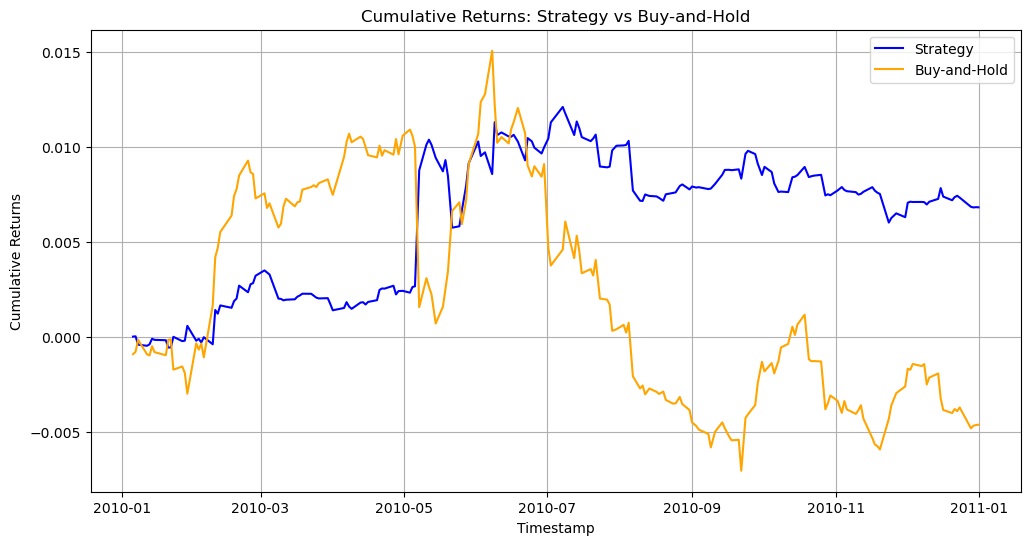

In [170]:
def plot_first_strategy(returns_df):
    """
    Plot cumulative returns for the strategy, and buy-and-hold portfolio.

    Parameters:
    - returns_df (pd.DataFrame): DataFrame with strategy, and buy-and-hold returns.
    """
    # Compute cumulative returns
    cumulative_portfolio = (1 + returns_df['portfolio']).cumprod() - 1
    cumulative_buy_and_hold = (1 + returns_df['buy_and_hold']).cumprod() - 1

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(returns_df['timestamp'], cumulative_portfolio, label="Strategy", color='blue')
    plt.plot(returns_df['timestamp'], cumulative_buy_and_hold, label="Buy-and-Hold", color='orange')
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Returns: Strategy vs Buy-and-Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_first_strategy(returns_df)

The market state-based strategy demonstrates the potential of exploiting market states derived from clustering for portfolio management. The strategy highlights the utility of state-based analysis to identify actionable market insights, thus providing a solid foundation for exploring advanced dynamic portfolio allocation approaches.